In [41]:
import numpy as np
from mpmath import mp
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_hp import *

mp.dps = 100  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2),
    ([1,1,-1], lambda J1, J2: -J2),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2),
    ([-1,1,1], lambda J1, J2: -J2)
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2),
    ([-1,-1,1], lambda J1, J2: -J2),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2),
    ([1,-1,-1], lambda J1, J2: -J2)
]

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def compute_J_prime_func(start, J_func):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = []
    for iL in range(3):
        for iR in range(3):
            d = (start + iR) - (1 + iL)
            distances.append((iL, iR, d))

    def collect_totals(is_pp):
        confsR = plus_configs if is_pp else minus_configs
        totals = []
        for spinsL, El_func in plus_configs:
            El = El_func(J1, J2)
            for spinsR, Er_func in confsR:
                Er = Er_func(J1, J2)
                Eint = mp.mpf(0)
                for iL_idx, iR_idx, d in distances:
                    sign = mp.mpf(spinsL[iL_idx] * spinsR[iR_idx])
                    Eint += sign * J_func(d)
                total = El + Er + Eint
                totals.append(total)
        return totals

    totals_pp = collect_totals(True)
    totals_pm = collect_totals(False)
    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    if log_R_pm == mp.ninf:
        return mp.inf
    return mp.mpf('0.5') * (log_R_pp - log_R_pm)

def mp_logsumexp(lst):
    if not lst:
        return mp.ninf
    a_max = max(lst)
    if mp.isinf(a_max):
        return a_max
    tmp = sum(mp.exp(a - a_max) for a in lst)
    return a_max + mp.log(tmp)

def generate_rg_flow_no_viz(J0, n, max_k, num_steps):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func)
            Jps.append(Jp)
        all_Js.append(Jps)
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
    return all_Js

def construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=5, epsilon=1e-6):
    all_Js = generate_rg_flow_no_viz(J0, n, max_k, num_steps)
    if len(all_Js) < 2:
        raise ValueError("Need at least 2 steps for derivatives")
    
    # Extract first matrix_size from last two steps
    J_k_minus_1 = all_Js[-2][:matrix_size]  # list of mp.mpf, truncated
    J_k = all_Js[-1][:matrix_size]  # list of mp.mpf, truncated
    
    M = matrix_size  # Size of matrix
    jac = np.zeros((M, M))
    
    # Define compute_T truncated to M
    def compute_T(J_vec_mp):
        J_dict = {r+1: J_vec_mp[r] for r in range(M)}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        J_prime = []
        for r in range(1, M+1):
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func)
            J_prime.append(Jp)
        return J_prime
    
    epsilon_mp = mp.mpf(epsilon)
    
    for s in range(M):
        J_pert_mp = [j for j in J_k_minus_1]  # copy list of mp
        J_pert_mp[s] += epsilon_mp
        T_pert_mp = compute_T(J_pert_mp)
        T_pert_float = np.array([float(j) for j in T_pert_mp])
        J_k_float = np.array([float(j) for j in J_k])
        jac[:, s] = (T_pert_float - J_k_float) / epsilon
    
    return jac

In [17]:
# Use case example
J0 = 2.0  # Initial J0
n = 1.5  # Exponent n
max_k = 1000  # Max distance for flow (thousands)
num_steps = 5  # Number of RG steps
matrix_size = 5  # Number of first J values for matrix

M_matrix = construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=matrix_size)
print("Recursion Matrix M:")
print(M_matrix)

# Optional: Compute exponents from the matrix
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
b = 3  # Scale factor
y = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
nu = 1 / y if y != 0 else np.inf
alpha = 2 - 1 / y if y != 0 else -np.inf
print(f"Largest eigenvalue λ_t = {lambda_t:.6f}")
print(f"ν = {nu:.6f}, α = {alpha:.6f}")

Recursion Matrix M:
[[ 9.99999997e-01  1.99999999e+00  2.00041396e+00  1.99999999e+00
   9.99999997e-01]
 [-6.38351080e+06 -6.38351080e+06 -6.38351080e+06 -6.38350980e+06
  -6.38350880e+06]
 [-6.14551337e+06 -6.14551337e+06 -6.14551337e+06 -6.14551337e+06
  -6.14551337e+06]
 [-3.92732295e+06 -3.92732295e+06 -3.92732295e+06 -3.92732295e+06
  -3.92732295e+06]
 [-2.78969924e+06 -2.78969924e+06 -2.78969924e+06 -2.78969924e+06
  -2.78969924e+06]]
Largest eigenvalue λ_t = -19246044.020628+0.000000j
ν = 0.065500, α = 1.934500


In [69]:
def calculate_exponents(n_values, max_k=1000, num_steps=10, matrix_size=5, b=3, epsilon=1e-6):
    nu_values = []
    alpha_values = []
    #for n in n_values:
    for _, n in enumerate(tqdm(n_values)):
        try:
            # Get critical J0 using find_J_c
            J0 = float(find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0))
            # Construct recursion matrix
            M_matrix = construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size, epsilon)
            # Get eigenvalues, take largest by absolute value
            eigenvalues = np.linalg.eigvals(M_matrix)
            eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
            lambda_t = eigenvalues[0]
            # Compute scaling dimension y
            y = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
            # Compute exponents
            nu = 1 / y if y != 0 else np.inf
            alpha = 2 - 1 / y if y != 0 else -np.inf
            nu_values.append(nu)
            alpha_values.append(alpha)
            #print(f"n={n:.2f}, J0={J0:.6f}, λ_t={lambda_t:.6f}, ν={nu:.6f}, α={alpha:.6f}")
        except Exception as e:
            #print(f"n={n:.2f}, error: {e}")
            nu_values.append(np.nan)
            alpha_values.append(np.nan)
    return nu_values, alpha_values

# Generate n values
n_values = np.linspace(0.75, 1.99, 25)
nu_values, alpha_values = calculate_exponents(
    n_values,
    max_k=5000,
    num_steps=5,
    matrix_size=5,
    b=3, epsilon=1e-3
)

100%|██████████| 25/25 [5:45:09<00:00, 828.37s/it]  


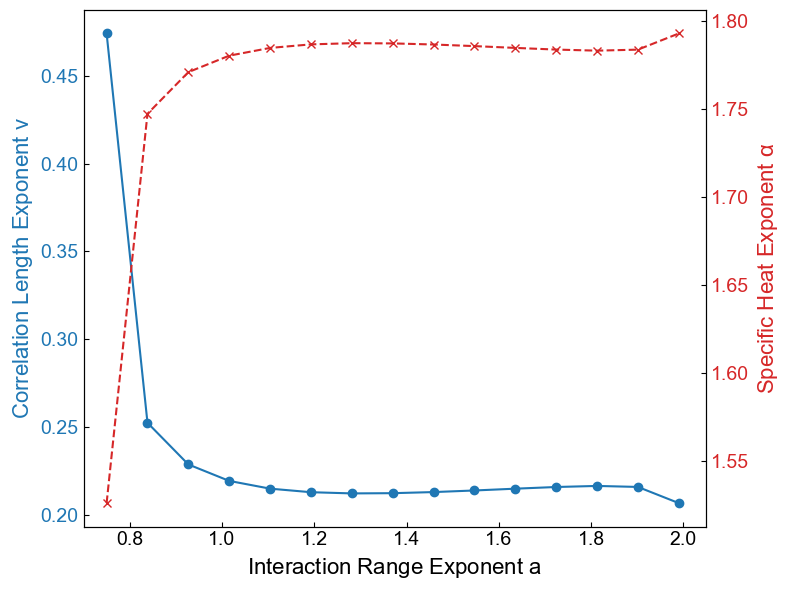

In [68]:
# Plot ν and α vs n
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

fig, ax1 = plt.subplots(figsize=(8, 6))
# Plot ν on left y-axis
color_nu = 'tab:blue'
ax1.set_xlabel('Interaction Range Exponent $a$', fontsize=16, fontweight='normal')
ax1.set_ylabel(r'Correlation Length Exponent $\nu$', fontsize=16, fontweight='normal', color=color_nu)
ax1.plot(n_values, nu_values, marker='o', linestyle='-', color=color_nu, label='ν')
ax1.tick_params(axis='x', direction='in', labelsize=14)
ax1.tick_params(axis='y', labelcolor=color_nu, direction='in', labelsize=14)
ax1.grid(False)
ax1.set_xlim(0.7, 2.05)

# Create second y-axis for α
ax2 = ax1.twinx()
color_alpha = 'tab:red'
ax2.set_ylabel(r'Specific Heat Exponent $\alpha$', fontsize=16, fontweight='normal', color=color_alpha)
ax2.plot(n_values, alpha_values, marker='x', linestyle='--', color=color_alpha, label='α')
ax2.tick_params(axis='y', labelcolor=color_alpha, direction='in', labelsize=14)
# Title and layout
#plt.title('Critical Exponents ν and α vs n')
fig.tight_layout()
#fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97), ncol=2)
plt.savefig('../results/critical_exponents_.png')
plt.show()

In [65]:
# For demonstration, create dummy nu_values and alpha_values
# Remove this when using the actual calculate_exponents function
#nu_values = np.zeros_like(n_values)  # Placeholder
#alpha_values = np.zeros_like(n_values)  # Placeholder

# Combine n_values, nu_values, and alpha_values into a single array
# Shape: (len(n_values), 3) where columns are [n, nu, alpha]
exponents_array = np.column_stack((n_values, nu_values, alpha_values))

# Save the array to a .npy file
np.save('../data/exponents_data.npy', exponents_array)

# Optional: Print the array to verify
print("Saved exponents array:")
print("Columns: [n, nu, alpha]")
print(exponents_array)

# To load the array later, you can use:
# loaded_array = np.load('exponents_data.npy')

Saved exponents array:
Columns: [n, nu, alpha]
[[0.75       0.07739009 1.92260991]
 [0.83857143 0.0811342  1.9188658 ]
 [0.92714286 0.08525463 1.91474537]
 [1.01571429 0.08981187 1.91018813]
 [1.10428571 0.09488079 1.90511921]
 [1.19285714 0.10055528 1.89944472]
 [1.28142857 0.10695459 1.89304541]
 [1.37       0.11423234 1.88576766]
 [1.45857143 0.12259011 1.87740989]
 [1.54714286 0.13229977 1.86770023]
 [1.63571429 0.14374264 1.85625736]
 [1.72428571 0.15748337 1.84251663]
 [1.81285714 0.174436   1.825564  ]
 [1.90142857 0.19635526 1.80364474]
 [1.99       0.22752541 1.77247459]]
